# CNNs en CIFAR10

En esta sección, se estudiará el comportamiento de redes neuronales convolucionales sobre el conjunto de imágenes CIFAR10, el cual se compone de 60000 imágenes de dimensión 32x32 pixeles, clasificadas en 10 categorías distintas. Las imágenes pertenecientes al dataset están en formato RGB y son representadas por un vector de dimensión 3072, donde los primeros 1024 elementos del vector representan la información del primer canal, los 1024 siguientes la información del segundo canal y finalmente los últimos 1024 elementos la información del tercer canal. 

Se debe señalar que durante el entrenamiento de las redes se utilizaron dos máquinas una utilizando una GPU (GeForce GTX 970) y otra sin GPU, por eso la significativa diferencia entre algunos entrenamientos.

In [1]:
# required imports
import keras
import tensorflow as tf
from keras.callbacks    import LearningRateScheduler
from keras.layers       import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.models       import Sequential
from keras.optimizers   import SGD, rmsprop


import _pickle as pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


# Importación del dataset

Se importa el conjunto de imágenes y se crean los conjuntos de entrenamiento, validación y pruebas, siguiendo el mismo procedimiento que en la tarea anterior, es decir se crea un conjunto de entrenamiento con 45000 elementos, un conjunto de validación con 5000 elementos y un conjunto de testeo con 10000 elementos.

In [2]:
def load_CIFAR_one(file_path):
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
    X = data_dict['data']
    Y = data_dict['labels']
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    
    #Creación de matrices de validación
    #Se fusionan los conjuntos Xtr e Ytr
    training_data = Xtr
    training_data_y = Ytr.reshape((50000, 1))
    training_data = np.append(training_data, training_data_y, axis=1)

    #Luego, se extrae el conjunto de validación a partir del conjunto de entrenamiento
    Xtr = training_data[:45000, :3072]
    Ytr = training_data[:45000, 3072]
    Xv = training_data[45000:, :3072]
    Yv = training_data[45000:, 3072]
    
    return Xtr, Ytr, Xte, Yte, Xv, Yv


x_train,y_train, x_test,y_test, x_val,y_val = load_CIFAR10('./data')
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Se normalizan las intensidades de los canales de las imágenes, para que estas pertenezcan al intervalo $[0, 1]$

In [3]:
x_train=x_train/255.0
x_test=x_test/255.0
x_val=x_val/255.0

Se visualizan algunos elementos del conjunto de imágenes

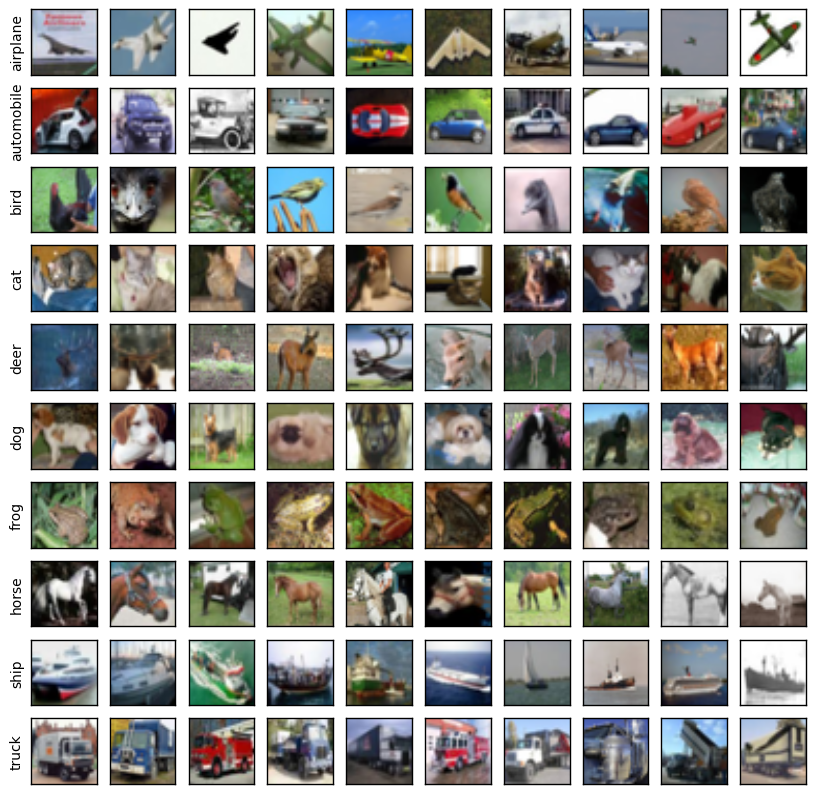

In [4]:
img_list = [[] for _ in range(10)]
list_full = False; i=0
while (not list_full):
    if ( len( img_list[ y_test[i] ] ) < 10 ):
        img_list[ y_test[i] ].append(i)
    i += 1
    
    list_full = True
    for j in range(10):
        if len(img_list[j]) < 10:
            list_full = False
            break;
            img_list
            
f, axarr = plt.subplots(10, 10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        v = img_list[i][j]
        axarr[i,j].imshow( x_test[v].reshape(3,32,32).transpose([1, 2, 0]) )
        axarr[i,j].get_xaxis().set_visible(False)
        axarr[i,j].get_yaxis().set_visible(False)
    axarr[i,0].set_ylabel( label_names[ y_test[v]] )
    axarr[i,0].get_yaxis().set_visible(True)
    axarr[i,0].get_yaxis().set_ticks([])
    
plt.show()

In [5]:
def plot_hist(hist, axis1 = None, axis2 = None):
    plt.figure(1,figsize=(12,5))

    plt.subplot(121)
    plt.plot(hist.history['loss'],     'go--', label = 'Training')
    plt.plot(hist.history['val_loss'], 'bo--', label = 'Validation')
    plt.legend(loc="upper right", fancybox= True)
    plt.xlabel(u'Numero de iteración')
    plt.ylabel('loss')
    if (axis1): 
        plt.axis(axis1)
    plt.grid(True)

    plt.subplot(122)
    plt.plot(hist.history['acc'],     'go--', label = 'Training')
    plt.plot(hist.history['val_acc'], 'bo--', label = 'Validation')
    plt.legend(loc="lower right", fancybox= True)
    plt.xlabel(u'Numero de iteración')
    plt.ylabel('acc')
    if (axis2):
        plt.axis(axis2)
    plt.grid(True)

    plt.show()

In [6]:
def model_eval(model, xt, yt):
    result = model.evaluate(xt, yt)
    print('\nloss: ' + str(result[0]) + ' - acc: ' + str(result[1]))

# Trasformación del dataset 

Se trasforman los vectores a matrices de 32x32, lo anterior para representar la información de las imágenes adecuadamente y poder realizar operaciones de convolución sobre estas, además se trasforman el vector con las etiquetas a una matriz binaria

In [7]:
num_classes = len(label_names)

x_train = x_train.reshape((x_train.shape[0],32,32,3))
#x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],32,32,3))
#x_test= x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
x_val= x_val.reshape((x_val.shape[0],32,32,3))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# Modelo CPCPFF

In [8]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

Se define una CNN con la estructura CPCPFF, las capas de convoluciones posen 64 filtros de 3x3 y utilizan funciones de activación ReLu, las capas de pooling utilizan filtros de 2x2 con stride 2, y finalmente la capa MLP se conforma de 512 neuronas. La red pose un total de 2141514 parámetros. Se puede apreciar que la entrada primero pasa por una capa convolucional de 64 filtros la cual pose 1792 parámetros, después se aplica una capa MaxPooling2D, la cual guarda el mayor valor por cada sub celda de 2x2, cambiando el tamaño de 32x32 en la entrada a 16x16 en la salida (un 75% de reducción), después se vuelve a aplicar una capa convolucional con la misma cantidad de filtos y con 36928 parámetros, igualmente se aplica una capa de pooling MaxPooling2D trasformando la entrada de 16x16 a 8x8, despues se una capa totalmente conectada con 512 nodos, 2097664 parámetros y la función ReLu, y finalmente se una capa de salida (softmax) con 10 neuronas.

# Entregamiento con SGD

In [9]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)

In [10]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, batch_size=500, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, callbacks=[lrate], verbose=1)
model.save('model/model-1c')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 123s - loss: 2.2767 - acc: 0.1653 - val_loss: 2.2491 - val_acc: 0.2328

Se entrena la red CNN utilizando el optimizador SGD con una tasa de aprendizaje que disminuye a medida que pasan las iteraciones, finalmente se utiliza la función de pérdida categorical crossentropy debido a la naturaleza del problema.

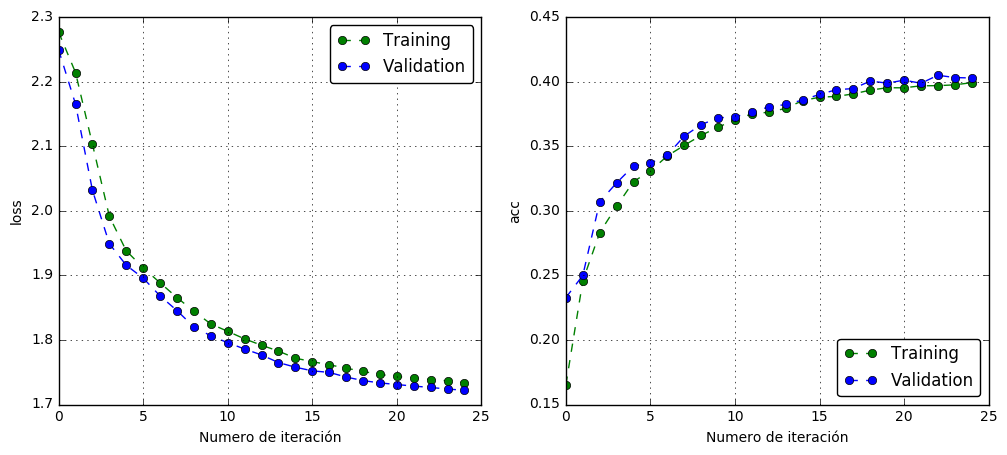

In [11]:
plot_hist(hist)

In [12]:
model_eval(model, x_test, y_test)

 9952/10000 [============================>.] - ETA: 0s 

A partir de los resultados obtenidos al entrenar el modelo es posible apreciar que la red entrenada no presenta overfiting, ya que no se observa una gran diferencia entre los valores de la perdida y la validación durante el entrenamiento, además se observa que durante las primeras 10 iteraciones los valores de la perdida y precisión cambian drásticamente debido a la naturaleza adaptiva en el factor de aprendizaje, finalmente el modelo construido obtiene una precisión del 40,28% sobre el conjunto de testeo. 

# Entrenamiento con RMSProp

In [24]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist_rms = model.fit(x_train, y_train, batch_size=500, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1d')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 125s - loss: 1.6652 - acc: 0.4276 - val_loss: 1.5937 - val_acc: 0.4319

Se entrena el mismo modelo del punto anterior, pero utilizando el optimizador rmsprop con un factor de aprendizaje igual a 0.001  y una taza de decaimiento igual a $10^{-6}$

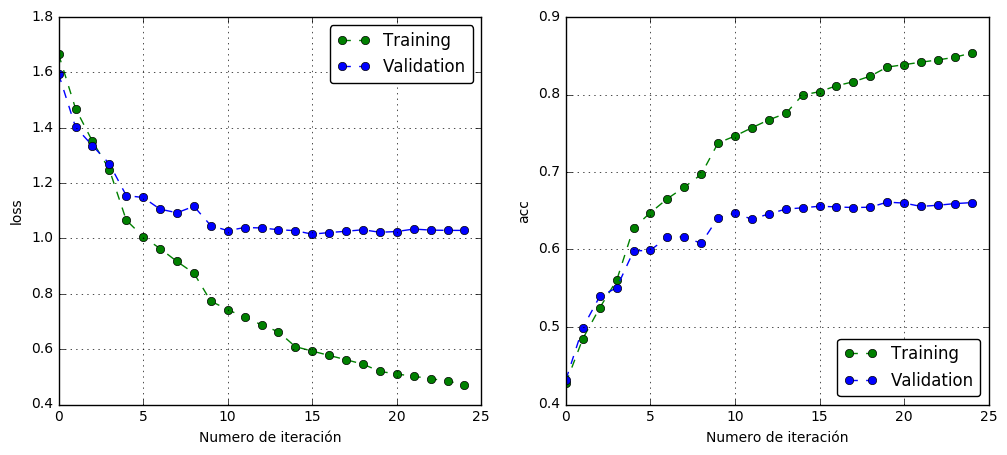

In [33]:
plot_hist(hist_rms)

In [26]:
model_eval(model, x_test, y_test)

 9984/10000 [============================>.] - ETA: 0s 

De los resultados obtenidos es posible apreciar que el modelo generado presenta overfiting, debido a la separación entre los valores obtenidos en la precisión obtenida en el entrenamiento y validación. Pero a pesar del overfiting del modelo, este fue capaz de obtener una precisión del 66.05% en la clasificación del conjunto de pruebas, lo cual resulta ser mayor que el resultado obtenido con el optimizador SGD.

# Duplicar la cantidad de capas de convolucionales
Se propone un cambio en la estructura del modelo, agregando una capa extra de convolución después de las capas de convolución ya presentes, con el objetivo de que el modelo pueda aprender mayores cualidades de la imagen antes reducir las dimensiones de la entrada realizadas por la capa de pooling (MaxPooling2D), además se propone la idea de cambiar la cantidad de filtros utilizada. 
## Mayor cantidad de filtros en la segunda convolución
Primero se evalúa la estructura propuesta de CCPCCPFF con una duplicación en la cantidad de filtros en el segundo grupo de convolución. 

In [27]:
model = Sequential()

# Frist CxCxP
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second CxCxP
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
__________

Del modelo generado se puede apreciar que posee un total de 4460106 parámetros, siendo casi una duplicación en la cantidad de los parámetros en comparación al modelo anteriormente estudiado, este aumento de parámetros puede implicar un overfiting mayor por parte del modelo, para evitar esto se agregan capas de dropout para disminuir el overfiting generado

In [30]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist_e1 = model.fit(x_train, y_train, batch_size=400, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1e')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 660s - loss: 1.8371 - acc: 0.3480 - val_loss: 1.7439 - val_acc: 0.3790

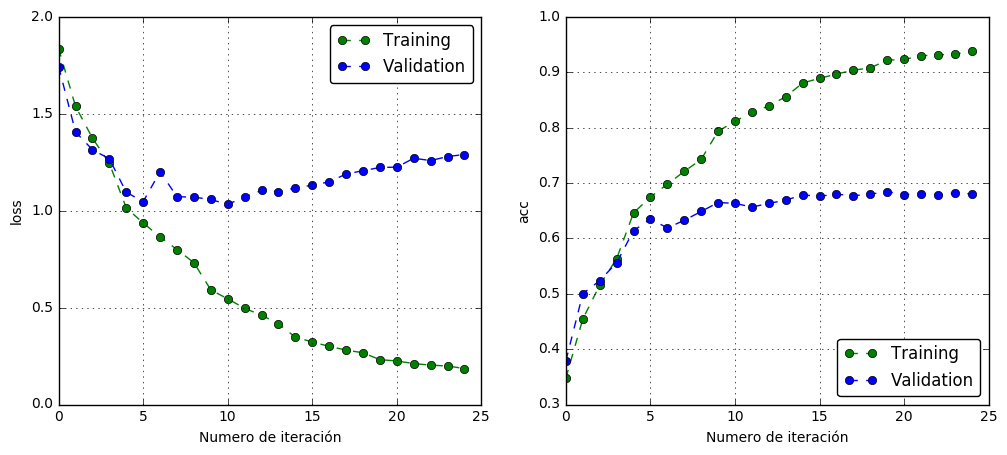

In [32]:
plot_hist(hist_e1)

In [34]:
model_eval(model, x_test, y_test)

10000/10000 [==============================] - 42s     

De los resultados obtenidos se aprecia que el modelo obtuvo un 68.04% de precisión sobre el conjunto de prueba, lo que significa una mejora con respecto al modelo anterior, indicando que las capas de pooling realizan una disminución prematura de la dimensionalidad de la entrada. De igual manera el modelo generado esta en presencia de overfiting, indicando que las capas de dropout no fueron suficientes para evitar el sobre ajustamiento del modelo a los datos utilizados durante el entrenamiento. 

## Mayor cantidad de filtros en la primera convolución
Se procede a entrenar el modelo CCPCCPFF planteado, pero duplicando la cantidad de filtros en el primer conjunto de convolución, además se utilizan un total de 3 capas de dropout para evitar el overfiting.  

In [25]:
model = Sequential()

# Frist CxCxP
model.add(Convolution2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second CxCxP
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        73792     
__________

Del modelo anterior se puede apreciar pose una menor cantidad de parámetros en comparación al primer modelo estudiado con la estructura CCPCCPFF, en específico pose 2364682 parámetros.

In [26]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, batch_size=250, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1e2')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 27s - loss: 1.9355 - acc: 0.3056 - val_loss: 1.5451 - val_acc: 0.4572
Epoch 2/25
45000/45000 [==============================] - 29s - loss: 1.5037 - acc: 0.4692 - val_loss: 1.3020 - val_acc: 0.5347
Epoch 3/25
45000/45000 [==============================] - 46s - loss: 1.3087 - acc: 0.5384 - val_loss: 1.1980 - val_acc: 0.5719
Epoch 4/25
45000/45000 [==============================] - 26s - loss: 1.1735 - acc: 0.5906 - val_loss: 1.1183 - val_acc: 0.6103
Epoch 5/25
45000/45000 [==============================] - 28s - loss: 1.0704 - acc: 0.6254 - val_loss: 1.0505 - val_acc: 0.6306
Epoch 6/25
45000/45000 [==============================] - 28s - loss: 0.9715 - acc: 0.6609 - val_loss: 0.9959 - val_acc: 0.6519
Epoch 7/25
45000/45000 [==============================] - 28s - loss: 0.8921 - acc: 0.6884 - val_loss: 1.0584 - val_acc: 0.6319
Epoch 8/25
45000/45000 [==============================

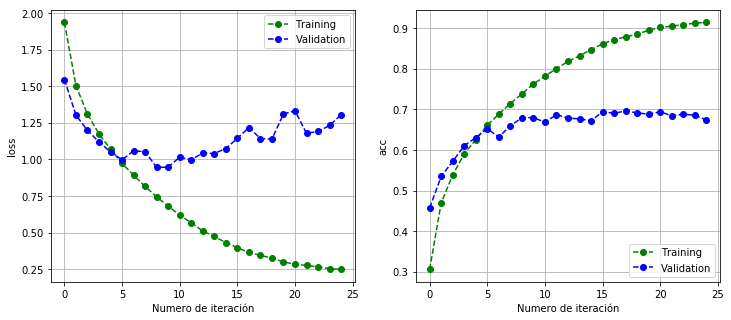

In [27]:
plot_hist(hist)

In [28]:
model_eval(model, x_test, y_test)

10000/10000 [==============================] - 3s     

loss: 1.30490230827 - acc: 0.674


El modelo después de ser entrenado obtuvo un 67.74% de precisión en la clasificación del conjunto de prueba, lo cual si bien el resultado es mejor que el obtenido en el modelo CPCPFF, no es mejor que el obtenido en el primer modelo CCPCCPFF generado, lo cual puede indicar que la red presenta una reducción prematura menor a la red CPCPFF, además que seguramente la red utiliza las primeras convoluciones para aprender las cualidades del conjunto de imágenes en general y que utiliza el segundo conjunto de convoluciones para aprender las cualidades de las imágenes que permiten distinguir las cualidades o patrones diferenciales entre cada clase de imagen.

## Misma cantidad de filtros, pero de mayor tamaño en la segunda parte. 
Finalmente se prueba creando un modelo CCPCCPFF donde se mantiene la cantidad de filtros, pero se aumenta el tamaño de estos en el segundo conjunto de convolución. 

In [8]:
model = Sequential()

# Frist CxCxP
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second CxCxP
model.add(Convolution2D(64, (6, 6), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (6, 6), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        147520    
__________

El modelo generado pose una cantidad total de 2436554 parámetros, lo cual es levemente anterior al segundo modelo CCPCCPFF, además se utilizaron la misma cantidad de capas de dropout ya utilizadas. 

In [10]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, batch_size=250, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1e3')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 19s - loss: 0.2767 - acc: 0.9066 - val_loss: 1.6715 - val_acc: 0.6825
Epoch 2/25
45000/45000 [==============================] - 18s - loss: 0.2552 - acc: 0.9164 - val_loss: 1.3890 - val_acc: 0.6863
Epoch 3/25
45000/45000 [==============================] - 18s - loss: 0.2535 - acc: 0.9161 - val_loss: 1.6987 - val_acc: 0.6924
Epoch 4/25
45000/45000 [==============================] - 18s - loss: 0.2482 - acc: 0.9171 - val_loss: 1.9033 - val_acc: 0.6913
Epoch 5/25
45000/45000 [==============================] - 18s - loss: 0.2396 - acc: 0.9201 - val_loss: 1.5397 - val_acc: 0.6693
Epoch 6/25
45000/45000 [==============================] - 19s - loss: 0.2340 - acc: 0.9219 - val_loss: 1.6047 - val_acc: 0.6946
Epoch 7/25
45000/45000 [==============================] - 19s - loss: 0.2362 - acc: 0.9222 - val_loss: 1.5968 - val_acc: 0.6777
Epoch 8/25
45000/45000 [==============================

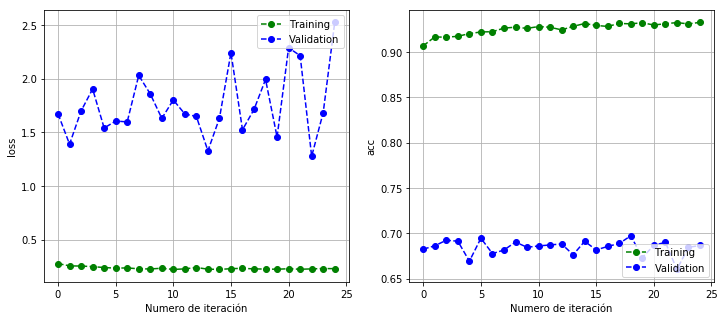

In [11]:
plot_hist(hist)

In [12]:
model_eval(model, x_test, y_test)

10000/10000 [==============================] - 2s     

loss: 2.52422398243 - acc: 0.6866


De los resultados obtenidos es posible apreciar que el overfiting del modelo aumento considerablemente en comparación a los otros modelos ya generados, además los ajustes que se realizan en los pesos de la red por cada epoch son mayores debido a los cambios drásticos en el factor de pérdida del conjunto de validación, y se aprecia que la distancia entre la precisión del conjunto de entrenamiento y validación permanece casi contante. Finalmente, el modelo puso clasificar un 68.66% del conjunto de prueba.

# Remplazar la capa de pooling por una convolución 

In [13]:
model = Sequential()

# Frist CxCxP
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))
model.add(Dropout(0.25))

# Second CxCxP
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       73856     
__________

Se propone cambiar las capas de poling por capas de convolucionales con stride 2, al realizar los cambios en el modelo CCPCCPCCP filtros más grandes en el segundo conjunto de convolución, se aprecia que la cantidad de parámetros es igual a 1982154, siendo esta cantidad menor a la de los modelos ya entrenados.  Además, se observa una disminución similar a la realizada por las capas de poling, ya que la dimensionalidad de la entrada cambia de 32x32 a 15x15 y posteriormente cambia de 15x15 a 7x7

In [ ]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, batch_size=50, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1f')

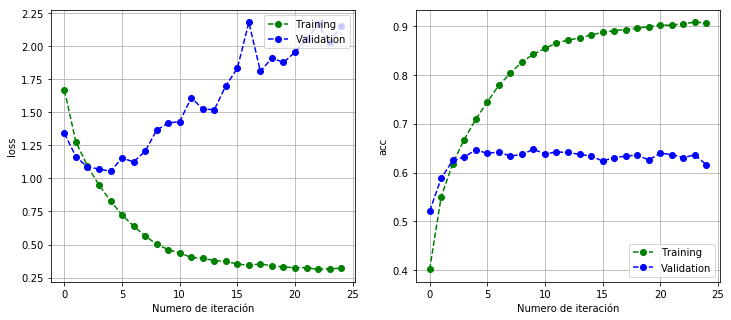

In [16]:
plot_hist(hist)

In [17]:
model_eval(model, x_test, y_test)

 9952/10000 [============================>.] - ETA: 0s
loss: 2.35201069355 - acc: 0.6222


Después de entrenar el modelo se aprecia que obtiene una precisión de 62.22% sobre el conjunto de prueba, lo cual resulta ser menor que los otros modelos entrenados con el mismo optimizador, además se aprecia un overfitin significativo. 

# Aumento del número de ejemplos. 
Se propone aumentar la cantidad de elementos del conjunto de entrenamiento, médiate la trasformación de los elementos que pertenecen a este, ya sean rotaciones, traslaciones, entre otras opciones. 

In [20]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,            # set input mean to 0 over the dataset
    samplewise_center=False,             # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,                 # apply ZCA whitening
    rotation_range=0,                    # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1,               # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1,              # randomly shift images vertically (fraction of height)
    horizontal_flip=True,                # randomly flip images
    vertical_flip=False)                 # randomly flip images
datagen.fit(x_train)

In [22]:
hist = model.fit_generator(
    datagen.flow(x_train, y_train,batch_size=500),
    steps_per_epoch=x_train.shape[0]// 500,
    epochs=25, validation_data=(x_val, y_val))
model.save('model/model-1g')

Epoch 1/25
90/90 [==============================] - 21s - loss: 2.0434 - acc: 0.3001 - val_loss: 1.3035 - val_acc: 0.5434
Epoch 2/25
90/90 [==============================] - 20s - loss: 1.7087 - acc: 0.3944 - val_loss: 1.4441 - val_acc: 0.5220
Epoch 3/25
90/90 [==============================] - 20s - loss: 1.5724 - acc: 0.4446 - val_loss: 1.1991 - val_acc: 0.5880
Epoch 4/25
90/90 [==============================] - 20s - loss: 1.4945 - acc: 0.4722 - val_loss: 1.1781 - val_acc: 0.5952
Epoch 5/25
90/90 [==============================] - 21s - loss: 1.4341 - acc: 0.4888 - val_loss: 1.2090 - val_acc: 0.5752
Epoch 6/25
90/90 [==============================] - 21s - loss: 1.3949 - acc: 0.5084 - val_loss: 1.0878 - val_acc: 0.6240
Epoch 7/25
90/90 [==============================] - 20s - loss: 1.3531 - acc: 0.5241 - val_loss: 1.2416 - val_acc: 0.5836
Epoch 8/25
90/90 [==============================] - 21s - loss: 1.3263 - acc: 0.5332 - val_loss: 1.0626 - val_acc: 0.6362
Epoch 9/25
90/90 [======

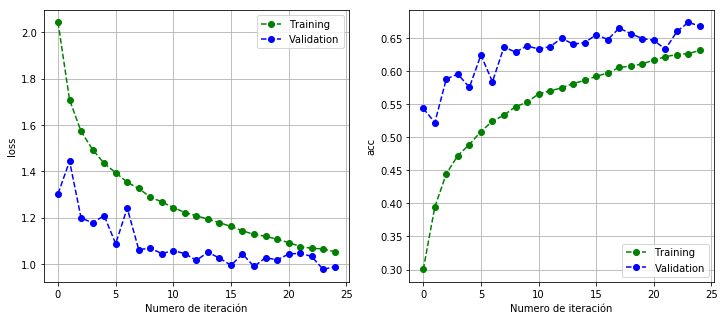

In [23]:
plot_hist(hist)

In [24]:
model_eval(model, x_test, y_test)

 9984/10000 [============================>.] - ETA: 0s
loss: 0.996783273029 - acc: 0.6642


Después de entrenar el último modelo creado, se puede apreciar una mejoría la precisión obtenida sobre el conjunto de pruebas siento esta igual a 66.42%, implicando que el aumento en el dataset permite una mejora en la precisión del modelo. De los gráficos objetivos se puede apreciar que los valores de validación son mejores que los de entrenamiento, lo cual puede indicar que al agregarse elementos al conjunto de entrenamiento aumenta la dificultad de este, haciendo que la red aprenda mejor las características principales del conjunto de imágenes, 

# Confusión en la clasificación

In [56]:
model = keras.models.load_model('model/model-1c')
y_precit = model.predict_classes(x_test)
y_real = y_test.argmax(axis=1)

confusion_matrix = np.zeros((10,10))
for i in range(len(y_real)):
    a = y_real[i]
    b = y_precit[i]
    confusion_matrix[a][b] = confusion_matrix[a][b] + 1 

print(confusion_matrix)

 9984/10000 [============================>.] - ETA: 0s[[ 495.   49.   61.   25.   22.   21.   25.   32.  206.   64.]
 [  50.  448.   11.   52.   11.   37.   46.   44.  108.  193.]
 [ 129.   53.  218.   89.  155.   97.  132.   54.   46.   27.]
 [  44.   64.   65.  273.   39.  240.  112.   56.   29.   78.]
 [  61.   31.  137.   65.  319.   64.  179.   83.   35.   26.]
 [  29.   37.   94.  175.   50.  392.   89.   68.   41.   25.]
 [  12.   30.  106.  101.  113.  108.  445.   38.   11.   36.]
 [  41.   73.   31.   74.   97.   91.   59.  393.   46.   95.]
 [ 118.   92.   18.   26.   13.   48.    7.   20.  555.  103.]
 [  42.  158.    8.   55.    9.   22.   29.   45.  142.  490.]]


In [57]:
for i in range(10):
    confusion_matrix[i][i]=0

for i in range(3):
    max_val = np.amax(confusion_matrix) 
    for x,y in np.argwhere(max_val==confusion_matrix):        
        print(label_names[x] + ' \t ' + label_names[y] + ' \t ' + str(max_val))
        confusion_matrix[x][y] = 0

cat 	 dog 	 240.0
airplane 	 ship 	 206.0
automobile 	 truck 	 193.0


De los pares que las redes tienen a confundir se aprecia que poseen cualidades en común, los perros y los gatos posen una morfología similar, 4 extremidades, una cola, y algunos colores similares de pelaje. En los aviones y barcos la presencia de agua y del cielo, además de materiales de construcción similares los cuales pueden estar pintados de colores similares, en general blanco. Y finalmente los autos con los camiones pertenecen a una categoría en común, vehículos terrestres motorizados, por lo que es esperable se tiendan a confundir. 